In [1]:
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import datetime as dt

import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [2]:
# Run for local database
HOST = 'http://localhost'
auth = None

In [59]:
# Run for hosted database
HOST = 'https://esida.informatik.haw-hamburg.de'
auth = HTTPBasicAuth('esida', 'opendata22')

# Get Shapes from database

In [3]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'region',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
regions_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    regions_gdf['geometry'] = geopandas.GeoSeries.from_wkt(regions_gdf['wkt'])
    regions_gdf = regions_gdf.drop(columns=['wkt'])

In [4]:
regions = dict(zip(regions_gdf.id, regions_gdf.name))
regions_Name2Id = dict(zip(regions_gdf.name, regions_gdf.id))

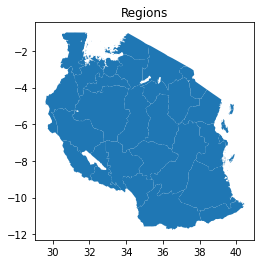

In [5]:
regions_gdf.plot()
plt.title('Regions')
plt.show()

In [6]:
len(regions_gdf)

31

In [71]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'district',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
districts_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    districts_gdf['geometry'] = geopandas.GeoSeries.from_wkt(districts_gdf['wkt'])
    districts_gdf = districts_gdf.drop(columns=['wkt'])

In [75]:
districts = dict(zip(districts_gdf.id, districts_gdf.name))

<AxesSubplot:>

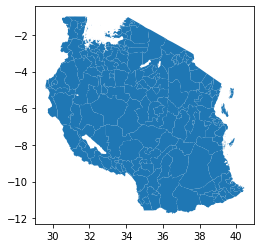

In [72]:
districts_gdf.plot()

# Get Parameter information

In [33]:
q = {
    'shape_id': regions_Name2Id['Songwe'],
    'da_spatial': True
}
d = requests.get(f"{HOST}/api/v1/parameters?{urlencode(q)}", auth=auth).json()

df = pd.DataFrame(d['data'])

In [34]:
loaded_parameters_df = df[df['loaded'] == True].sort_values(by='temporal_coverage', ascending=False).reset_index(drop=True)

In [35]:
loaded_parameters_df

,loaded,parameter_id,spatial_coverage,temporal_actual,temporal_coverage,temporal_expected,temporal_first,temporal_last,timelines
0,True,worldpop_popc,0.992968,10.0,0.909091,11,2011,2020,year
1,True,tnhp_clinical_officer,NaN,5.0,0.454545,11,2014,2018,year
2,True,tnhp_nurse,NaN,5.0,0.454545,11,2014,2018,year
3,True,statcompiler_housing,NaN,4.0,0.363636,11,2010,2017,year
4,True,statcompiler_sanitation,NaN,4.0,0.363636,11,2010,2017,year
5,True,worldpop_age_0_9,0.992968,2.0,0.181818,11,2019,2020,year
6,True,worldpop_sexage,0.992968,2.0,0.181818,11,2019,2020,year
7,True,rcmrd_elevthresh,0.998714,1.0,0.090909,11,2018,2018,year
8,True,chirps_tprecit,1.000000,5.0,0.001245,4017,2018-01-01,2018-01-05,date
9,True,meteo_dtr,NaN,2.0,0.000498,4017,2011-05-22,2013-04-05,date


In [36]:
loaded_parameters = loaded_parameters_df['parameter_id'].values

In [37]:
loaded_parameters

array(['worldpop_popc', 'tnhp_clinical_officer', 'tnhp_nurse',
       'statcompiler_housing', 'statcompiler_sanitation',
       'worldpop_age_0_9', 'worldpop_sexage', 'rcmrd_elevthresh',
       'chirps_tprecit', 'meteo_dtr', 'fao_drought', 'tnbs_garbage'],
      dtype=object)

In [40]:
spatial_df = pd.DataFrame(d['spatial_details'])

In [46]:
spatial_df.sort_values(by='coverage', ascending=True).head(5)

,coverage,file,nodata_cells,parameter_id,valid_cells
49,0.992968,tza_f_50_2020.tif,18038.0,worldpop_sexage,2547040
72,0.992968,tza_m_20_2019.tif,18038.0,worldpop_sexage,2547040
71,0.992968,tza_m_1_2020.tif,18038.0,worldpop_sexage,2547040
70,0.992968,tza_m_1_2019.tif,18038.0,worldpop_sexage,2547040
69,0.992968,tza_m_15_2020.tif,18038.0,worldpop_sexage,2547040


# Get map of temporal coverage

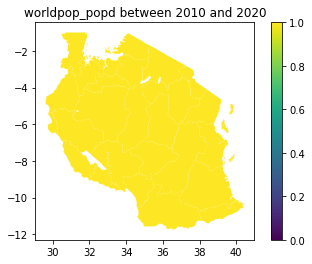

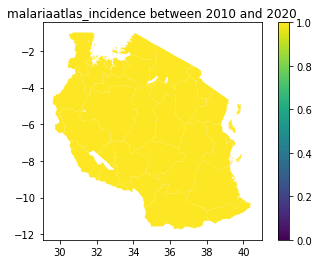

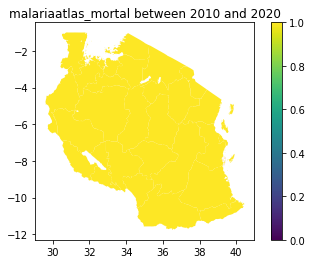

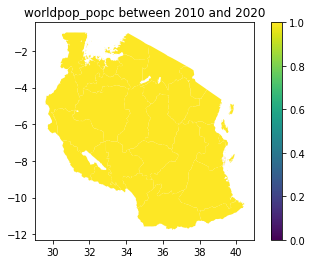

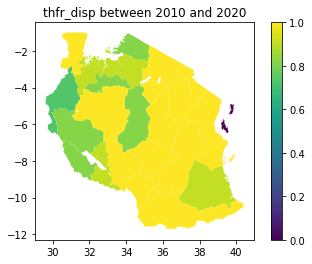

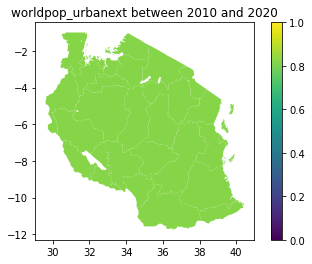

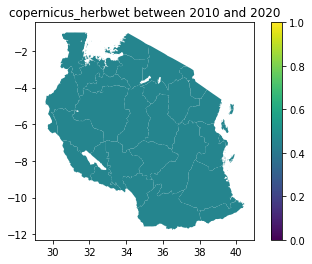

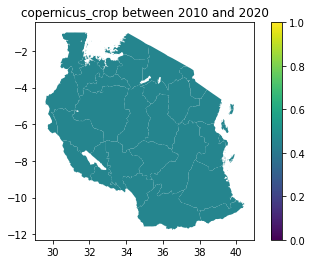

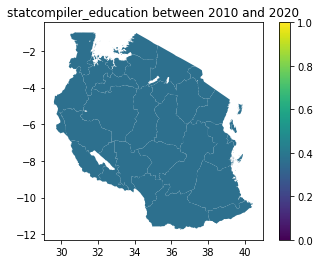

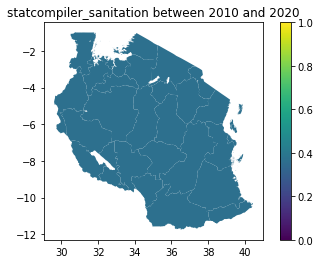

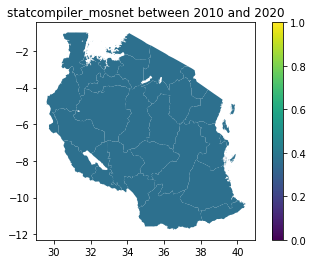

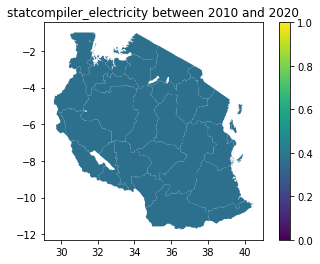

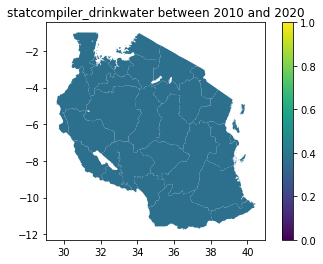

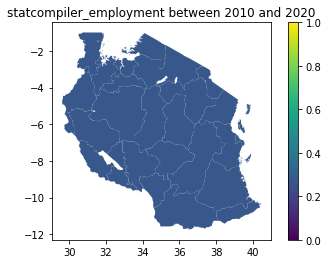

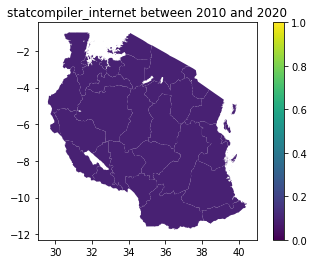

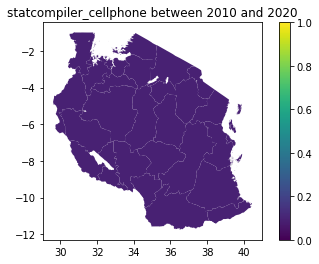

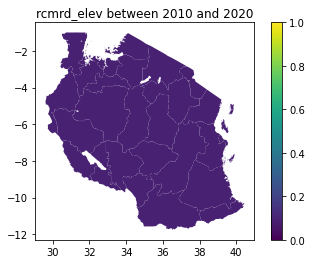

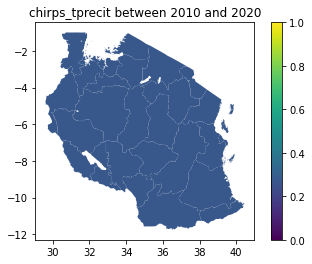

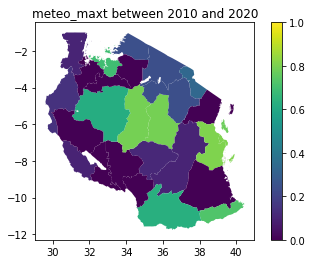

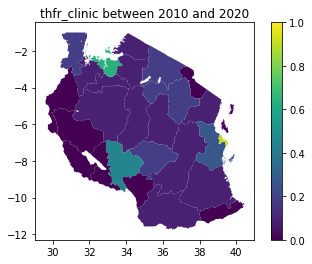

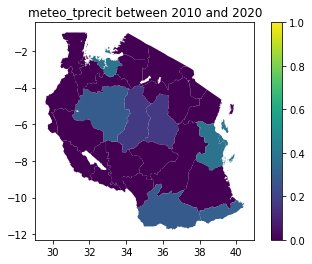

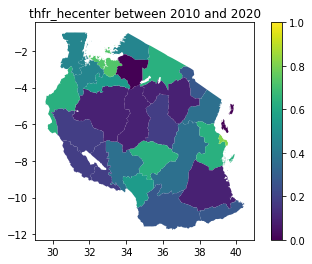

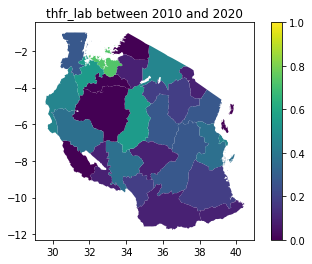

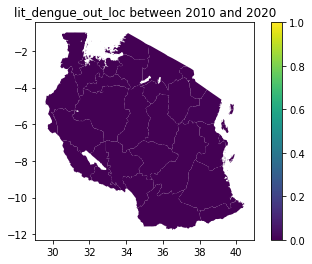

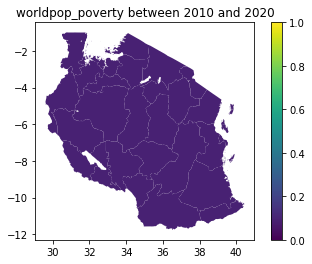

In [101]:
cache = {}
for parameter_id in loaded_parameters:
    rows = []

    for name, shape_id in regions_Name2Id.items():
        if shape_id not in cache:
            q = {
                'shape_id': shape_id,
            }
            d = requests.get(f"{HOST}/api/v1/parameters?{urlencode(q)}", auth=auth).json()

            cache[shape_id] = pd.DataFrame(d['data'])
        dfx = cache[shape_id]
        row = {
            'id': shape_id,
            'value': dfx[dfx['parameter_id'] == parameter_id].reset_index(drop=True).at[0, 'temporal_coverage']
        }
        rows.append(row)

    dfxv = pd.DataFrame(rows)
    gdfxv = regions_gdf.merge(dfxv, on='id')

    gdfxv.plot(column='value',  vmin=0, vmax=1, legend=True)
    plt.title(f"{parameter_id} between 2010 and 2020")
    plt.show()

# Spatial coverage

**ATTENTION**: takes very long!

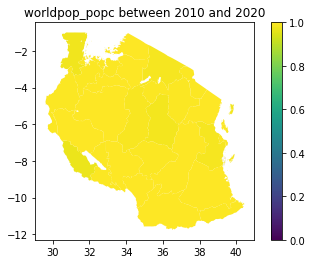

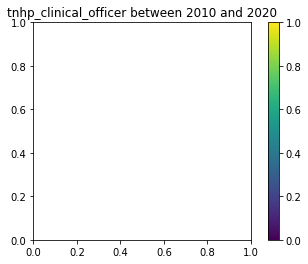

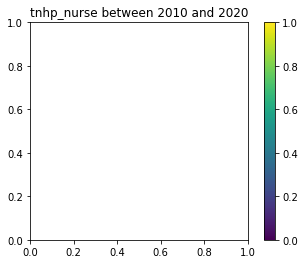

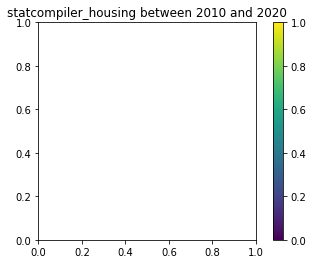

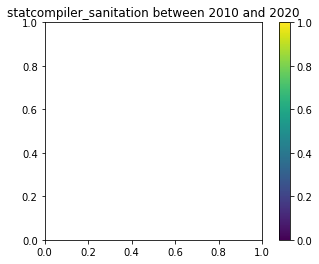

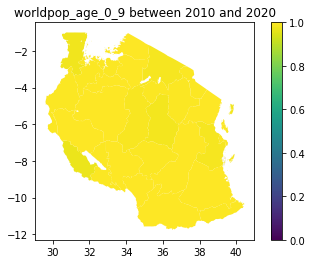

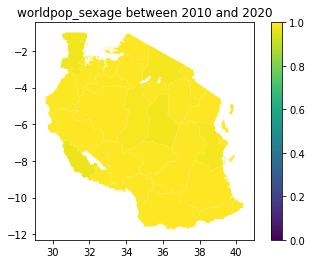

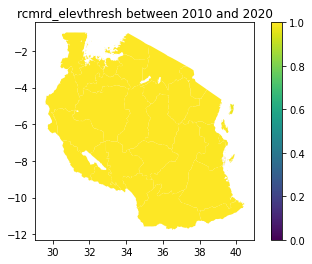

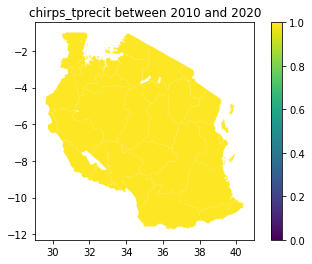

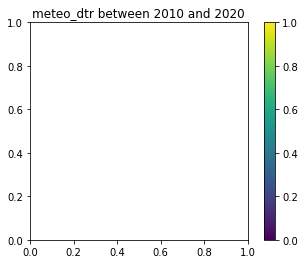

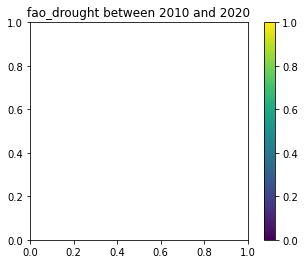

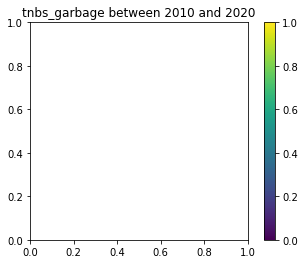

In [30]:
cache = {}
for parameter_id in loaded_parameters:
    rows = []

    for name, shape_id in regions_Name2Id.items():
        if shape_id not in cache:
            q = {
                'shape_id': shape_id,
                'da_spatial': True
            }
            d = requests.get(f"{HOST}/api/v1/parameters?{urlencode(q)}", auth=auth).json()

            cache[shape_id] = pd.DataFrame(d['data'])
        dfx = cache[shape_id]
        row = {
            'id': shape_id,
            'value': dfx[dfx['parameter_id'] == parameter_id].reset_index(drop=True).at[0, 'spatial_coverage']
        }
        rows.append(row)

    dfxv = pd.DataFrame(rows)
    gdfxv = regions_gdf.merge(dfxv, on='id')

    gdfxv.plot(column='value',  vmin=0, vmax=1, legend=True)
    plt.title(f"{parameter_id} between 2010 and 2020")
    plt.show()

# Spatial coverage for a single parameter

In [50]:
p = 'worldpop_popd'
q = {}
d = requests.get(f"{HOST}/api/v1/da_spatial/{p}?{urlencode(q)}", auth=auth).json()

df = pd.DataFrame(d['data'])

In [57]:
# Total spatial completness over all files (mean)
d['data_quality']

{'spatial_coverage': 0.9951079938821222}

In [59]:
# per file / per shape coverage
df.head(5)

,coverage,file,nodata_cells,parameter_id,shape_id,valid_cells
0,0.986538,tza_pd_2001_1km_UNadj.tiff,663.0,worldpop_popd,1,48586
1,0.994528,tza_pd_2001_1km_UNadj.tiff,237.0,worldpop_popd,2,43071
2,0.996700,tza_pd_2001_1km_UNadj.tiff,51.0,worldpop_popd,3,15405
3,1.000000,tza_pd_2001_1km_UNadj.tiff,0.0,worldpop_popd,4,32728
4,1.000000,tza_pd_2001_1km_UNadj.tiff,0.0,worldpop_popd,5,82835


In [65]:
spatial_coverage = []
for shape_id, name in regions.items():
    dfx = df[df['shape_id'] == shape_id]
    spatial_coverage.append({
        'id': shape_id,
        'coverage': dfx['coverage'].mean()
    })

In [66]:
spatial_coverage_df = pd.DataFrame(spatial_coverage)

<AxesSubplot:>

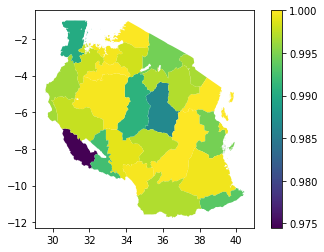

In [70]:
regions_gdf.merge(spatial_coverage_df, on='id').plot(column='coverage', legend=True)

In [76]:
spatial_coverage = []
for shape_id, name in districts.items():
    dfx = df[df['shape_id'] == shape_id]
    spatial_coverage.append({
        'id': shape_id,
        'coverage': dfx['coverage'].mean()
    })
spatial_coverage_df = pd.DataFrame(spatial_coverage)

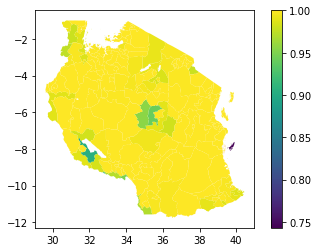

In [80]:
ax = districts_gdf.merge(spatial_coverage_df, on='id').plot(column='coverage', legend=True)
#districts_gdf.plot(ax=ax, facecolor='none', ec='black')